# Discrete generative models


In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy.special as sps

<a id="synthetic"></a>
## Generating discrete generative models

The generative model $p(\mathbf{x})$ is 
$$
\mathbf{x} \sim \text{Discrete}(\mathbf{p}_x(\mathbf{z})), \qquad \mathbf{z} \sim \text{Discrete}(\mathbf{p}_z)
$$
where targets $\mathbf{x} \in \mathbb{R}^{D_x}$ and latents $\mathbf{z} \in \mathbb{R}^{D_z}$. 
The generative function is defined by a random neural network $\mathbf{f}(\mathbf{z})$ used in 
$$
\mathbf{p}_x(\mathbf{z}) = \text{softmax}(\beta \mathbf{f}(\mathbf{z}))
$$
where $\beta$ controls how peaked the generative process is ($\beta \to \infty$ gives a deterministic model). 

Because latent and target spaces are discrete, we can enumerate the exact marginal 
$$
p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{x} \mid \mathbf{z}) \, p(\mathbf{z}) 
$$
and we can store the values $p(\mathbf{x})$ in a big matrix/tensor after computing this once. 

Now for a challenge instance, we randomly generate 
- $\mathbf{f}(\mathbf{z})$ as a mixture of Gaussians with parameters given by a random MLP
- $\beta$ value drawn from some density over $[0, \infty)$

We set 
- $\mathbf{p}_z$ as a discretized truncated Gaussian prior

We compute 
- $p(\mathbf{x})$
- Sample $\mathbf{x}_* \sim p(\mathbf{x})$

At this point, no one knows the true $\mathbf{z}_*$ that gives rise to $\mathbf{x}_*$, but we are guaranteed there is a solution since this is the exact marginal distribution of the generative model. 

TODO:
- Difficulty parameters?
- Solution criterion (maybe $p(\mathbf{x}_* \mid \mathbf{z}_{\text{submit}}) > p_{\text{threshold}}$)?

In [2]:
def Glorot_initialization(rng, in_dims, hidden_layers, out_dims):
    """
    Modify with random normal biases
    
    :param np.random.Generator rng: random number generator
    :param list[int] hidden_layers: list of hidden layer sizes
    :param int out_dims: output dimension
    :return:
        Ws: list of weights
        bs: list of biases
    """
    Ws, bs = [], []
    prev_layers = [in_dims] + hidden_layers[:-1]
    for prev_layer_size, layer_size in zip(prev_layers, hidden_layers):
        W = rng.normal(0, 1, (prev_layer_size, layer_size)) * np.sqrt(2 / (prev_layer_size + layer_size))
        b = np.zeros((1, layer_size))#rng.normal(0, 1, (1, layer_size)) * np.sqrt(2 / (prev_layer_size + layer_size))
        
        Ws.append(W)
        bs.append(b)
        
    prev_layer_size = hidden_layers[-1]
    W = rng.normal(0, 1, (prev_layer_size, out_dims)) * np.sqrt(2 / (prev_layer_size + out_dims))
    b = np.zeros((1, out_dims))#rng.normal(0, 1, (1, out_dims)) * np.sqrt(2 / (prev_layer_size + layer_size))
    Ws.append(W)
    bs.append(b)
    
    return Ws, bs


def f_MLP(z, Ws: list[np.ndarray], bs: list[np.ndarray], activation):
    """
    :param np.ndarray x: inputs (num_samps, D_z)
    :return:
        outputs (num_samps, out_dims)
    """
    n_layers = len(Ws) - 1
    for i in range(n_layers):
        W, b = Ws[i], bs[i]
        z = activation(z @ W + b)
        
    return z @ Ws[-1] + bs[-1]

In [3]:
def sample_discrete_p(rng, p, grid_size: list[int], num_samps: int):
    """
    :param np.ndarray p: (*grid_size_z)
    :param list[int] grid_size: grid size
    :param int num_samps: number of samples to draw
    :return:
        np.ndarray: (num_samps, grid_dims)
    """
    return np.array([np.unravel_index(rng.choice(np.prod(grid_size), p=p.flatten()), grid_size) for _ in range(num_samps)])

In [4]:
def f(zs, MLP, grid_size_x, rank):
    X, Y = np.meshgrid(np.arange(grid_size_x[0]), np.arange(grid_size_x[1]))
    X = X.flatten()
    Y = Y.flatten()
    pos = np.stack([X, Y], axis=1)[:, None, :]  # (num_locs, 1, D_x)
    
    theta = 30. * MLP(zs)[:, 0]  # (num_samps,)
    
    r_1, r_2 = grid_size_x[0] / 3, grid_size_x[1] / 3
    mu = np.stack([grid_size_x[0] / 2 + r_1 * np.cos(theta), grid_size_x[1] / 2 + r_2 * np.sin(theta)], axis=1)  # (num_samps, D_x)

    A = 3. * MLP(zs)[:, 1:].reshape(-1, D_x, rank)
    prec = A @ A.transpose(0, 2, 1) + 0.2 * np.eye(D_x)  # (num_samps, D_x, D_x)

    W_final = np.exp(-0.5 * np.sum(((pos - mu)[..., None, :] @ prec) * (pos - mu)[..., None, :], axis=-1))[..., 0]
    W_final = W_final / np.sum(W_final, axis=0)

    return W_final.T  # (num_samps, num_locs)

In [5]:
rng = np.random.default_rng(123)  # seed numpy random number generator

D_z = 1
grid_size_z = [64]
D_x = 2
grid_size_x = [64, 64]

prior_z = sps.softmax(- 0.0005 * (np.arange(grid_size_z[0]) - grid_size_z[0] / 2)**2 )



# run random generation
hidden_layers = [4, 8, 4]
rank = 3
out_dims = 1 + rank * D_x
Ws, bs = Glorot_initialization(rng, D_z, hidden_layers, out_dims)

num_samps = 9
beta = 10.
zs = sample_discrete_p(rng, prior_z, grid_size_z, num_samps)

MLP = lambda z: f_MLP(z, Ws, bs, np.tanh)


out_dims = np.prod(grid_size_x)
inputs = (zs - grid_size_z[0] / 2) / grid_size_z[0]
logits_x = f(inputs, MLP, grid_size_x, rank)
p_x = sps.softmax(beta * logits_x, axis=-1)
p_x = p_x.reshape(-1, *grid_size_x)


# convert to one-hot
zs_onehot = np.zeros((num_samps, *grid_size_z))
zs_onehot[np.arange(num_samps), zs.flatten()] = 1

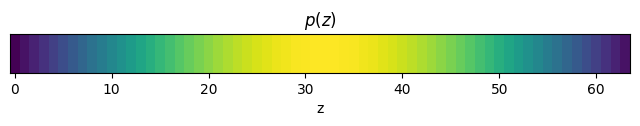

In [6]:
plt.figure(figsize=(8, 0.5))
plt.imshow(prior_z[:, None].T, origin='lower', cmap='viridis', aspect='auto')
plt.title(r'$p(z)$')
plt.xlabel('z')
plt.yticks([])
plt.show()

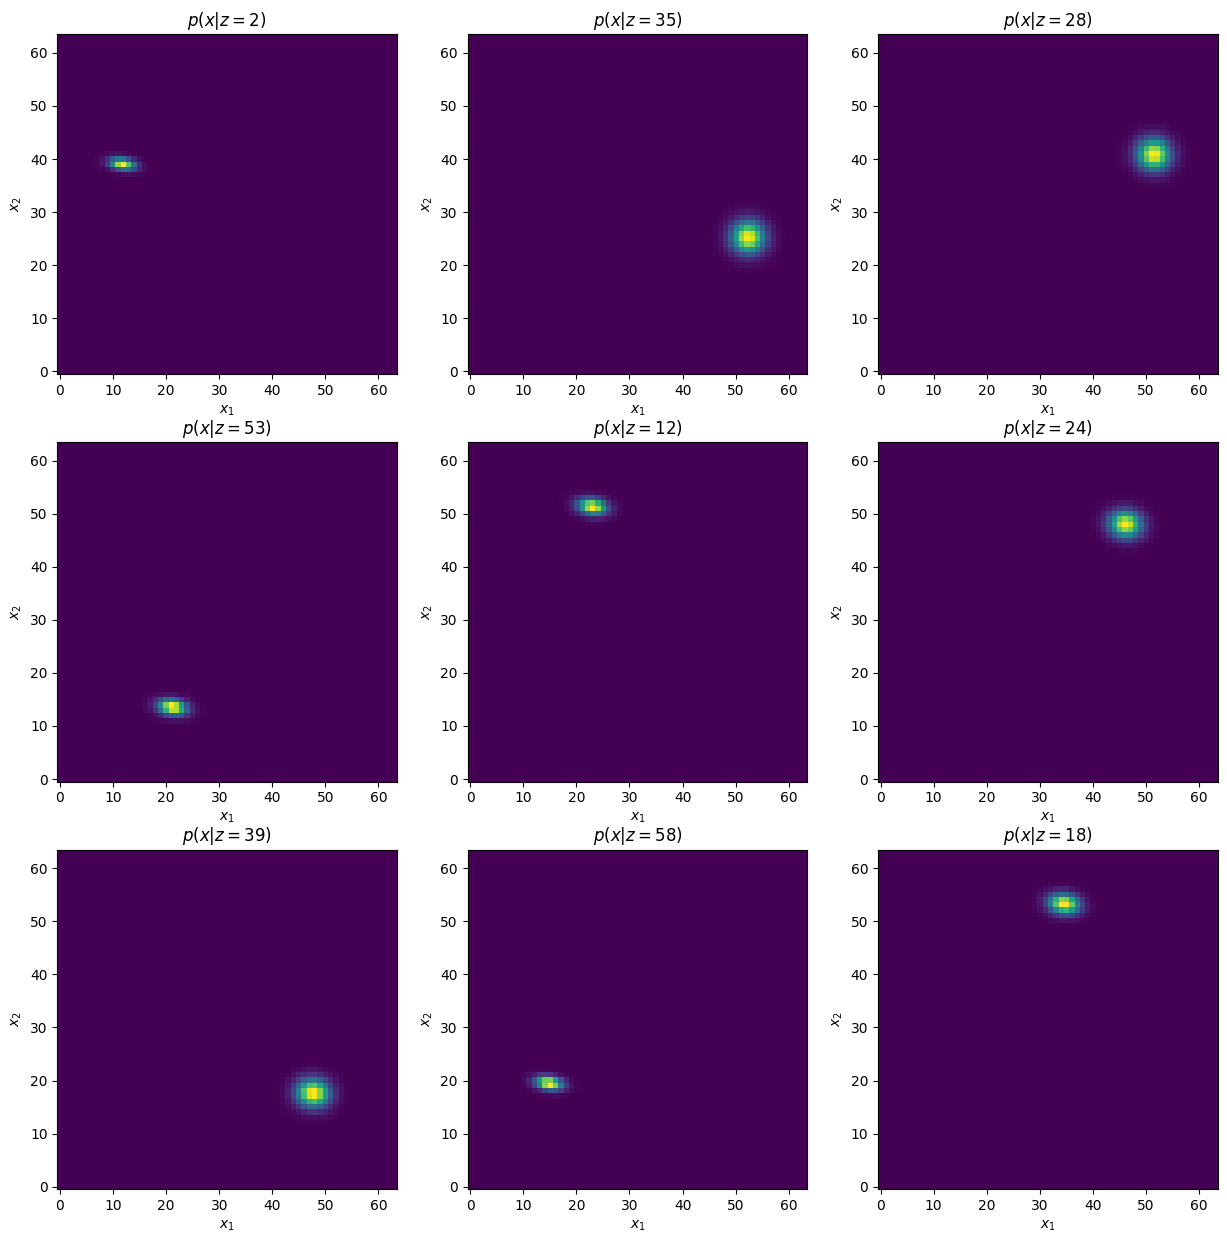

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for samp_id, ax in enumerate(axes.flatten()):
    ax.imshow(p_x[samp_id], origin='lower')
    ax.set_title(rf'$p(x|z = {zs[samp_id, 0]})$')
    
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title(rf'$p(x|z = {zs[samp_id, 0]})$')
    
plt.show()


In [8]:
f_z = lambda z: f(z, MLP, grid_size_x, rank)


def enumerate_p_x(p_z, beta, f_z, batch_size: int, grid_size_x: list[int], grid_size_z: list[int]):
    """
    Marginalize p(x,z) using enumeration over latent z
    
    :param np.ndarray p_z: (num_samps, *grid_size_z)
    :param float beta: temperature parameter
    :param callable f_z: function to compute p(x|z)
    :param int batch_size: batch size for enumeration (split total number of summation points into batches)
    :param list[int] grid_size_x: size of grid for x
    :param list[int] grid_size_z: size of grid for z
    :return:
        np.ndarray: (*grid_size_x)
    """
    # generate one hot values for z
    z_onehot = np.eye(np.prod(grid_size_z))
    
    num_pts = z_onehot.shape[0]
    num_batches = int(np.ceil(num_pts / batch_size))
    
    for _ in range(len(grid_size_x)):
        p_z = np.expand_dims(p_z, axis=-1)
        
    p_x = np.zeros(grid_size_x)
    for i in range(num_batches):
        print(f'Batch {i + 1}/{num_batches}...')
        p_z_batch = p_z[i * batch_size: (i + 1) * batch_size]
        z_batch = np.argmax(z_onehot[i * batch_size: (i + 1) * batch_size], axis=-1)[:, None]
        
        inputs = (z_batch - grid_size_z[0] / 2) / grid_size_z[0]
        logits_x = f_z(inputs)
        p_x += (p_z_batch * sps.softmax(beta * logits_x, axis=-1).reshape(-1, *grid_size_x)).sum(0)
    
    return p_x
    

In [9]:
marg_p_x = enumerate_p_x(prior_z, beta, f_z, 32, grid_size_x, grid_size_z)

Batch 1/2...
Batch 2/2...


In [10]:
marg_p_x.sum()

np.float64(0.9999999999999951)

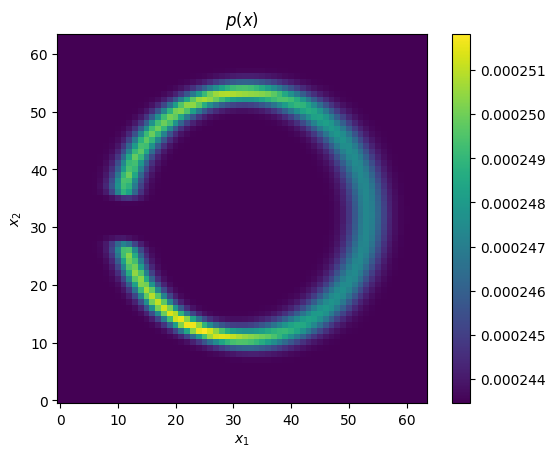

In [11]:
plt.imshow(marg_p_x, origin='lower')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'$p(x)$')
plt.show()